# Baselines

In [ ]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import numpy as np
from time import time
import tensorflow as tf

from sgptools.utils.data import *
from sgptools.utils.misc import *
from sgptools.utils.metrics import *
from sgptools.utils.tsp import run_tsp
from sgptools.utils.gpflow import get_model_params

from sgptools.models.bo import *
from sgptools.models.cma_es import *
from sgptools.models.greedy_mi import *
from sgptools.models.greedy_sgp import *
from sgptools.models.continuous_sgp import *
from sgptools.models.core.transformations import IPPTransform

import matplotlib.pyplot as plt

np.random.seed(1234)
tf.random.set_seed(1234)

## Set the initial parameters and generate synthetic data
(no distance budget constraints)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value               │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.0                 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)    │ float64 │ [3. 3.]             │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.09999999999999999 │


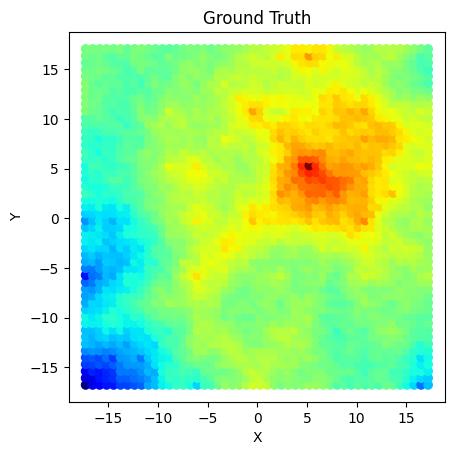

In [2]:
num_robots = 2
num_placements = 10

# Configure IPPTransform
transform = IPPTransform(num_robots=num_robots)

# Get the synthetic elevation data
X_train, y_train, X_test, y_test, candidates, X, y = get_dataset()

# Train the GP and get the model parameters
_, noise_variance, kernel = get_model_params(X_train, y_train, 
                                             lengthscales=[3.0, 3.0], 
                                             optimizer='scipy',
                                             max_steps=0)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='jet')
plt.title("Ground Truth")
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_aspect('equal')
plt.show()

# Get the initial waypoints
Xu_init = get_inducing_pts(X_train, num_placements*num_robots)
Xu_init, _ = run_tsp(Xu_init, 
                     num_vehicles=num_robots,
                     max_dist=100,
                     resample=num_placements)
Xu_init = Xu_init.reshape(-1, 2)

## Helper functions

In [3]:
# Convert a given path to the data (X, y) alongst the path
def path2data(path, X, y):
    data_X = []
    data_y = []
    num_robots, _, _ = path.shape
    for r in range(num_robots):
        X_new, y_new = cont2disc(path[r], X, y)
        data_X.extend(X_new)
        data_y.extend(y_new)
    return np.array(data_X), np.array(data_y)

# Plot the solution paths
def plot_paths(paths, title=None):
    plt.figure()
    for i, path in enumerate(paths):
        plt.plot(path[:, 0], path[:, 1], 
                 c='r', label='Path', 
                 zorder=1, marker='o')
    if title is not None:
        plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')

 ## Continuous-SGP

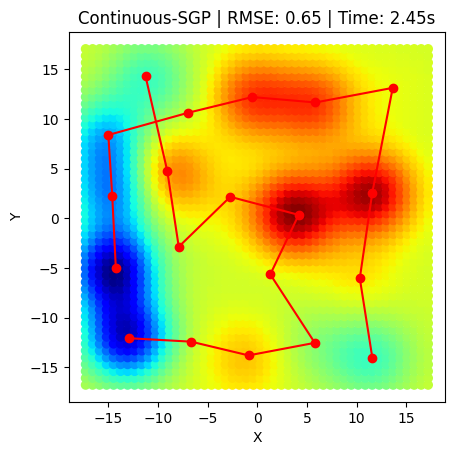

In [4]:
start = time()
model, _ = continuous_sgp(num_placements, 
                          X_train, 
                          noise_variance, 
                          kernel,
                          transform,
                          Xu_init=Xu_init.copy())
end = time()
run_time = end - start

# Get solution inducing points
sol = model.inducing_variable.Z.numpy()
sol_paths = sol.reshape(num_robots, num_placements, 2)

# Convert solution path waypoints to sensing points along the whole path
X_path, y_path = path2data(sol_paths, X, y)

# Compute RMSE
y_pred, _ = get_reconstruction((X_path, y_path), 
                                X, 
                                noise_variance, 
                                kernel)
rmse = get_rmse(y_pred, y)

# Plot the solution
plot_paths(sol_paths, title=f"Continuous-SGP | RMSE: {rmse:.2f} | Time: {run_time:.2f}s")
plt.scatter(X[:, 0], X[:, 1], c=y_pred, zorder=0, cmap='jet')
plt.gca().set_aspect('equal')

 ## Discrete-SGP

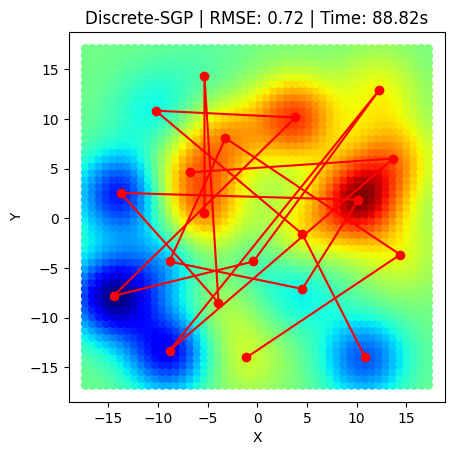

In [5]:
start = time()
sol = get_greedy_sgp_sol(num_placements*num_robots, 
                         candidates, 
                         candidates, 
                         noise_variance, 
                         kernel,
                         transform=transform)
end = time()
run_time = end - start
sol_paths = sol.reshape(num_robots, num_placements, 2)

# Convert solution path waypoints to sensing points along the whole path
X_path, y_path = path2data(sol_paths, X, y)

# Compute RMSE
y_pred, _ = get_reconstruction((X_path, y_path), 
                                X, 
                                noise_variance, 
                                kernel)
rmse = get_rmse(y_pred, y)

# Plot the solution
plot_paths(sol_paths, title=f"Discrete-SGP | RMSE: {rmse:.2f} | Time: {run_time:.2f}s")
plt.scatter(X[:, 0], X[:, 1], c=y_pred, zorder=0, cmap='jet')
plt.gca().set_aspect('equal')

 ## Greedy Mutual Information

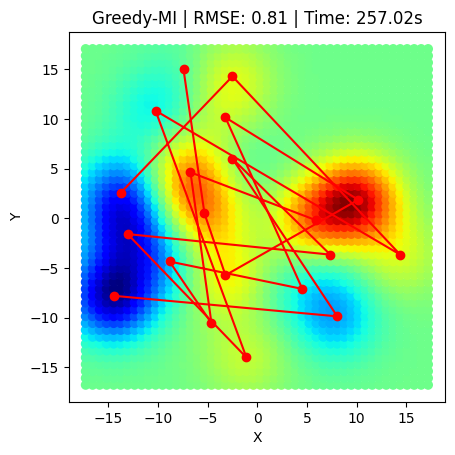

In [6]:
start = time()
sol = get_greedy_mi_sol(num_placements*num_robots, 
                        candidates, 
                        candidates, 
                        noise_variance, 
                        kernel,
                        transform=transform)
end = time()
run_time = end - start
sol_paths = sol.reshape(num_robots, num_placements, 2)

# Convert solution path waypoints to sensing points along the whole path
X_path, y_path = path2data(sol_paths, X, y)

# Compute RMSE
y_pred, _ = get_reconstruction((X_path, y_path), 
                                X, 
                                noise_variance, 
                                kernel)
rmes = get_rmse(y_pred, y)

# Plot the solution
plot_paths(sol_paths, title=f"Greedy-MI | RMSE: {rmes:.2f} | Time: {run_time:.2f}s")
plt.scatter(X[:, 0], X[:, 1], c=y_pred, zorder=0, cmap='jet')
plt.gca().set_aspect('equal')

 ## CMA-ES Mutual Information (Genetic Algorithm)

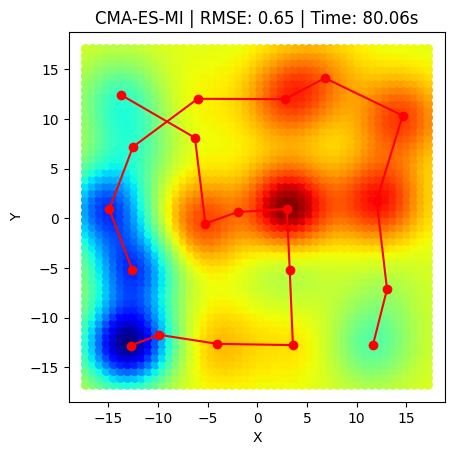

In [7]:
start = time()
model = CMA_ES(candidates, 
               noise_variance, 
               kernel, 
               transform=transform)
sol = model.optimize(num_sensors=num_placements*num_robots, 
                     X_init=Xu_init.copy())
end = time()
run_time = end - start
sol_paths = sol.reshape(num_robots, num_placements, 2)

# Convert solution path waypoints to sensing points along the whole path
X_path, y_path = path2data(sol_paths, X, y)
y_pred, _ = get_reconstruction((X_path, y_path), 
                                X, 
                                noise_variance, 
                                kernel)

# Compute RMSE
rmes = get_rmse(y_pred, y)

# Plot the solution
plot_paths(sol_paths, title=f"CMA-ES-MI | RMSE: {rmes:.2f} | Time: {run_time:.2f}s")
plt.scatter(X[:, 0], X[:, 1], c=y_pred, zorder=0, cmap='jet')
plt.gca().set_aspect('equal')

## Bayesian Optimization Mutual Information

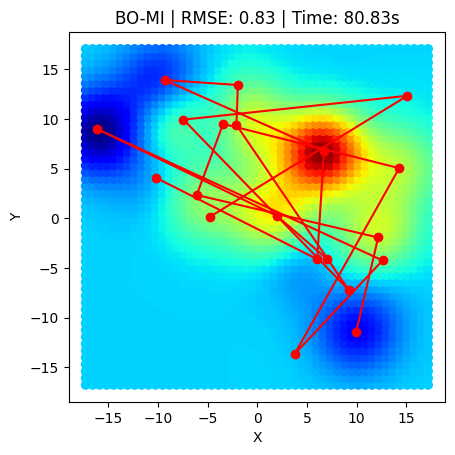

In [8]:
start = time()
model = BayesianOpt(candidates, 
                    noise_variance,
                    kernel,
                    transform=transform)
sol = model.optimize(num_sensors=num_placements*num_robots, 
                     X_init=Xu_init.copy())
end = time()
run_time = end - start
sol_paths = sol.reshape(num_robots, num_placements, 2)

# Convert solution path waypoints to sensing points along the whole path
X_path, y_path = path2data(sol_paths, X, y)
y_pred, _ = get_reconstruction((X_path, y_path), 
                                X, 
                                noise_variance, 
                                kernel)

# Compute RMSE
rmes = get_rmse(y_pred, y)

# Plot the solution
plot_paths(sol_paths, title=f"BO-MI | RMSE: {rmes:.2f} | Time: {run_time:.2f}s")
plt.scatter(X[:, 0], X[:, 1], c=y_pred, zorder=0, cmap='jet')
plt.gca().set_aspect('equal')